## AdaGrad算法

在之前介绍过的优化算法中，目标函数自变量的每一个元素在相同时间步都使用同一个学习率来自我迭代。如果学习率过小，那么梯度较小的维度梯度更新太慢；如果学习率过大，那么容易在梯度过大的维度上发散（震荡）。AdaGrad算法则根据自变量在每个维度的梯度值的大小来调整各个维度上的学习率，从而避免统一的学习率难以适应所有维度的问题。

在每一时间步$t$，引入变量$\vec{s}_t$（初始化为$\vec{0}$），

$$
\vec{s}_t \leftarrow \vec{s}_{t-1} + \vec{g}_{t} \odot \vec{g}_t,
$$

并将待优化参数$\vec{x}_t$中每个元素的学习率通过按元素运算重新调整一下：

$$
\vec{x}_t \leftarrow \vec{x}_{t-1} - \frac{\eta}{\sqrt{\vec{s}_t + \epsilon}} \odot \vec{g}_t,
$$

其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-6}$。

观察上式可发现，如果目标函数有关自变量中某个元素的偏导数一直都较大，那么该元素的学习率将下降较快；反之，如果目标函数有关自变量中某个元素的偏导数一直都较小，那么该元素的学习率将下降较慢。然而，由于$\vec{s}_t$一直在累加按元素平方的梯度，自变量中每个元素的学习率在迭代过程中一直在降低（或不变）。所以，**当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad算法在迭代后期由于学习率过小，可能较难找到一个有用的解**。

示例：

epoch 20, x1 -2.382563, x2 -0.158591


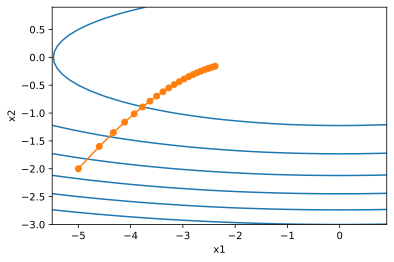

In [1]:
%matplotlib inline
import math
import torch
import my_utils
import matplotlib.pyplot as plt
import numpy as np

def adagrad_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6  # 前两项为自变量梯度
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
# my_utils.show_trace_2d(f_2d, my_utils.train_2d(adagrad_2d))
my_utils.use_svg_display()
plt.plot(*zip(*my_utils.train_2d(adagrad_2d)), '-o', color='#ff7f0e')
x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
plt.contour(x1, x2, f_2d(x1, x2), colors='#1f77b4')
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig('adagrad1.svg')

上图验证了当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad算法在迭代后期由于学习率过小，可能较难找到一个有用的解。

epoch 20, x1 -0.002295, x2 -0.000000


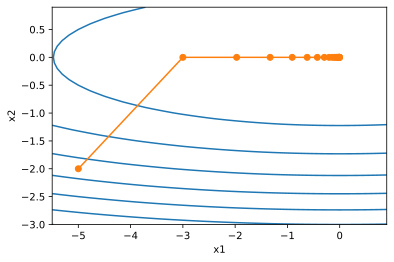

In [2]:
eta = 2
# my_utils.show_trace_2d(f_2d, my_utils.train_2d(adagrad_2d))
my_utils.use_svg_display()
plt.plot(*zip(*my_utils.train_2d(adagrad_2d)), '-o', color='#ff7f0e')
x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
plt.contour(x1, x2, f_2d(x1, x2), colors='#1f77b4')
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig('adagrad2.svg')

增大学习率后自变量更为迅速地逼近了最优解。

### 1 从零开始实现

In [10]:
features, labels = my_utils.get_NASA_data()

def init_adagrad_states():
    s_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        s.data += (p.grad.data**2)
        p.data -= hyperparams['lr'] * p.grad.data / torch.sqrt(s + eps)

loss: 0.242548, 0.066101 sec per epoch


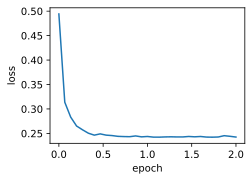

In [11]:
my_utils.opt_train(adagrad, init_adagrad_states(), {'lr': 0.1}, features, labels)

### 2 简洁实现

loss: 0.244593, 0.054217 sec per epoch


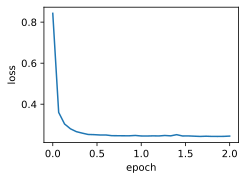

In [12]:
my_utils.opt_train_torch(torch.optim.Adagrad, {'lr': 0.1}, features, labels)